<a class="anchor" id="toc-go-back"></a>
# Assignment 3: Day-ahead scheduling from the perspective of the system operator

### Table of Contents
* [1. Loading the data](#data-loading)
* [2. Setup optimization problem](#optimziation-problem-setup)
* [3. Running the optimization model ](#run-optimization)
* [4. Can we solve the problem using machine learning?](#machine-learning)
* [5. Extra ](#extra)

First of all, we refer to the hand-in for an in-depth description of the problem formulation and the optimization problem. This notebooks focuses on implementing the model using ```Gurobipy``` and an additional part using machine learning. 

We start by loading the relevant modules.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import gurobipy as grb

In [2]:
DATA_DIR = Path('../data')

<a class="anchor" id="data-loading"></a>
## 1. Loading the data

We initially load the data files given to us with the assignment description. This will later on be used as input to the optimization model from which we can then find the optimal values of the decision variables.

In [3]:
# Load data files from csv-files
pmax    = pd.read_csv(DATA_DIR / 'pgmax.csv')
pmin    = pd.read_csv(DATA_DIR / 'pgmin.csv')
ru      = pd.read_csv(DATA_DIR / 'ramp.csv')
UT      = pd.read_csv(DATA_DIR / 'lu.csv')
DT      = pd.read_csv(DATA_DIR / 'ld.csv')    
demand  = pd.read_csv(DATA_DIR / 'demand.csv', sep=';')   
c_op    = pd.read_csv(DATA_DIR / 'cost_op.csv') 
c_st    = pd.read_csv(DATA_DIR / 'cost_st.csv') 
PTDF    = pd.read_csv(DATA_DIR / 'PTDF.csv', sep=';') 
busgen  = pd.read_csv(DATA_DIR / 'busgen.csv', sep=';')
busload = pd.read_csv(DATA_DIR / 'busload.csv', sep=';')
fmax    = pd.read_csv(DATA_DIR / 'fmax.csv')

# 
Hg      = pd.DataFrame(np.dot(PTDF, busgen), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Gen {i+1}' for i in range(busgen.shape[1])])
Hl      = pd.DataFrame(np.dot(PTDF, busload), index=[f'Line {i+1}' for i in range(PTDF.shape[0])], columns=[f'Load {i+1}' for i in range(busload.shape[1])])

# Load load profile samples
samples = pd.read_csv(DATA_DIR / 'samples.csv', header=None)

With the data set loaded, we can now define the basics underlying the optimization problem - thus, we start by defining the numerical values of the parameters.

In [4]:
N_g     = busgen.shape[1]   # the number of generator units
N_t     = demand.shape[0]   # next 24 hours
N_load  = busload.shape[1]  # the number of load buses
N_lines = PTDF.shape[0]     # the number of transmission lines

<a class="anchor" id="optimization-problem-setup"></a>
## 2. Setup optimization problem

Differences between the hand-in and the proposed formula from class:
1. start-up cost is deterministic and should not be optimized for (i.e. input parameter and not decision variable)
2. demand is additionally indexed by time for the flow constraint
3. the start-up constraint is added by specifying an on/off variable for each unit at each time, $b$.

Now, we are ready to define the decision variables of the optimization problem. These relate to the start-up status and production of generator units at each time step of the day. We additionally include a variable for denoting the on/off status. As we are given a data file for start-up costs for each generation unit, we approach the problem with the start-up cost being time-independent and consider it as an input rather than a decision variable.

Next, we add the constraints to the optimization model. Overall these concern:
1) Power balance equation, i.e. the total production must equal the total demand. Here, we add the concept of slack variable for feasibility - i.e. making sure that the problem can be solved even if in some cases the demand is not met.
2) Generation limits, ensuring that the generator units do not produce more than their maximum capacity.
3) Ramp-up and ramp-down constraints, ensuring...
4) Line technical limits, ensuring that the flow between busses does not exceed the maximum capacity of the line.
5) Minimum on/off times.
6) Start-up constraints for turning on a generator unit (i.e. the unit must be off in the previous time step).

Lastly, we define the objective function for the optimization problem. This is defined as minimizing the total cost - i.e. production cost and start-up cost. In this case, we assume deterministic start-up costs for each generator unit - in other words, we assume that they are time-independent.

These three steps have been implemented in a wrapper object related to the 118-bus system, namely the ```BUS118```-class defined below.

In [5]:

import gurobipy as grb
from tqdm import tqdm

class BUS118:
    
    def __init__(self, 
        N_g, N_t, N_load, N_lines, 
        demand,
        pmin, pmax,
        Hg, Hl, fmax,
        UT, DT, ru,
        c_op, c_st,
    ):
        
        # Define numerical parameters
        self.N_g        = N_g
        self.N_t        = N_t
        self.N_load     = N_load
        self.N_lines    = N_lines

        # Define input data
        self.demand     = demand
        self.pmin       = pmin
        self.pmax       = pmax
        self.fmax       = fmax
        self.UT         = UT
        self.DT         = DT
        self.ru         = ru
        self.c_op       = c_op
        self.c_st       = c_st
        self.Hg         = Hg
        self.Hl         = Hl

    def define_decision_variables(self):
        # Add variables for each generator unit at each time step for specifying on/off and start-up status
        self.b      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='b')
        self.u      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.BINARY, name='u')
        
        # Add variable denoting the power output of each generator unit at each time step
        self.p      = self.model.addVars(self.N_g, self.N_t, vtype=grb.GRB.CONTINUOUS, name='p')

        # We add slack variables for ensuring feasability of the power balance equations
        self.eps    = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='eps')
        self.delta  = self.model.addVars(self.N_t, 1, vtype=grb.GRB.CONTINUOUS, name='delta')

        # Make variable updates effective
        self.model.update()
    
    def define_constraints(self, load_profile):
        
        self.demand_profile = (self.demand * load_profile)

        for t in tqdm(range(self.N_t), desc='Adding constraints...'):
            ### POWER BALANCE EQUATION ###
            # Add power balance constraints for each time step
            self.model.addConstr(grb.quicksum(self.p[g_n, t] for g_n in range(self.N_g)) == grb.quicksum(self.demand_profile.iloc[t, n] for n in range(self.N_load)) + self.eps[t, 0] - self.delta[t, 0], name=f'power_balance[{t}]')
            
            # Add positive constraints for the slack variables
            self.model.addConstr(self.eps[t, 0] >= 0)
            self.model.addConstr(self.delta[t, 0] >= 0)

            for g in range(self.N_g):
                
                ### GENERATION LIMITS ###
                self.model.addConstr(self.b[g, t] * self.pmin.iloc[g, 0] <= self.p[g, t], name=f'generation_limit[{g},{t}]')
                self.model.addConstr(self.b[g, t] * self.pmax.iloc[g, 0] >= self.p[g, t], name=f'generation_limit[{g},{t}]')
                
                if t >= 1:
                    ### GENERATOR ON/OFF AND START-UP STATUS ###
                    self.model.addConstr(self.u[g, t] >= self.b[g, t] - self.b[g, t-1], name=f'start_up_constraint[{g},{t}]')

                    ### RAMPING CONSTRAINTS ###
                    self.model.addConstr(self.p[g, t] - self.p[g, t-1] <= self.ru.iloc[g, 0], name=f'ramping_up[{g},{t}]')
                    self.model.addConstr(self.p[g, t-1] - self.p[g, t] <= self.ru.iloc[g, 0], name=f'ramping_down[{g},{t}]')

                    ### MINIMUM ON TIME ###
                    min_on_time_generator = min(self.UT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_on_time_generator):
                        self.model.addConstr(-self.b[g, t-1] + self.b[g, t] - self.b[g, tau] <= 0, name=f'min_on_time_constraint[{g},{t},{tau}]')
                    
                    ### MINIMUM OFF TIME ###
                    min_off_time_generator = min(self.DT.iloc[g, 0] + t - 1, self.N_t)
                    for tau in range(t, min_off_time_generator):
                        self.model.addConstr(self.b[g, t-1] - self.b[g, t] + self.b[g, tau] <= 1, name=f'min_off_time_constraint[{g},{t},{tau}]')
                                
            ### LINE FLOW LIMITS ###
            for l in range(self.N_lines):
                line_expr1  = grb.quicksum(self.Hg.iloc[l, g_n] * self.p[g_n, t] for g_n in range(self.N_g)) 
                line_expr2  = grb.quicksum(self.Hl.iloc[l, n] * self.demand_profile.iloc[t, n] for n in range(self.N_load))
                line_expr   = line_expr1 - line_expr2 - self.eps[t, 0] + self.delta[t, 0]
                                
                # LHS
                self.model.addConstr(line_expr <= self.fmax.iloc[l].item(), name=f'pos_line_flow_limit[{l},{t}]')
                # RHS
                self.model.addConstr(-self.fmax.iloc[l].item() <= line_expr, name=f'neg_line_flow_limit[{l},{t}]')

        self.model.update()
    
    def define_objective(self, M: int = 1):
        # Set minimization objective function
        minimum_objective   = grb.quicksum(self.c_op.iloc[g, 0] * self.p[g, t] + self.c_st.iloc[g, 0] * self.u[g, t] for g in range(self.N_g) for t in range(self.N_t))
        # Set slack objective function
        slack_objective     = M * grb.quicksum(self.eps[t, 0] + self.delta[t, 0] for t in range(self.N_t))

        # Set objective function
        self.model.setObjective(sense=grb.GRB.MINIMIZE, expr=minimum_objective + slack_objective)
        self.model.update()

    def setup_model(self, load_profile, M: int = 1000):
        # Set up optimization model
        self.model = grb.Model()
        self.define_decision_variables()
        self.define_constraints(load_profile)
        self.define_objective(M=M)

    def optimize(self, load_profile, M: int = 1000):
        # Initialize model
        self.setup_model(load_profile, M)
        # Run optimization
        return self.model.optimize()

<a class="anchor" id="run-optimization"></a>
## 3. Running the optimization model

For being able to run experiments, the optimization model has been collected in an object - namely, the ```BUS118```-class. 

In [6]:
system = BUS118(
    N_g=N_g, N_t=N_t, N_load=N_load, N_lines=N_lines,
    demand=demand,
    pmin=pmin, pmax=pmax,
    Hg=Hg, Hl=Hl, fmax=fmax,
    UT=UT, DT=DT, ru=ru,
    c_op=c_op, c_st=c_st,
)

In [7]:
# Select a load profile
load_profile = samples.iloc[0, :].values[np.newaxis, :] 

# Optimize system with specified load profile
opt = system.optimize(load_profile, M=10000)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


Adding constraints...:   0%|          | 0/24 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Adding constraints...: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11375H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 23006 rows, 3936 columns and 474938 nonzeros
Model fingerprint: 0x4708f060
Variable types: 1344 continuous, 2592 integer (2592 binary)
Coefficient statistics:
  Matrix range     [5e-07, 4e+02]
  Objective range  [8e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 4163 rows and 30 columns
Presolve time: 0.91s
Presolved: 18843 rows, 3906 columns, 310191 nonzeros
Variable types: 1368 continuous, 2538 integer (2538 binary)

Root relaxation: objective 3.573630e+05, 427 iterations, 0.07 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

In [8]:
# Prepare data format for results
on_off      = -1 * np.ones((system.N_g, system.N_t))
start_up    = -1 * np.ones((system.N_g, system.N_t))
power       = -1 * np.ones((system.N_g, system.N_t))
cost        = -1 * np.ones((system.N_g, system.N_t))
raw_op      = -1 * np.ones((system.N_g, system.N_t))
raw_st      = -1 * np.ones((system.N_g, system.N_t))
delta       = -1 * np.ones((system.N_t, 1))
eps         = -1 * np.ones((system.N_t, 1))

# Extract results
for t in range(24):
    for g in range(N_g):
        # Generator dependent results
        on_off[g, t]    = system.b[g, t].x
        start_up[g, t]  = system.u[g, t].x
        power[g, t]     = system.p[g, t].x
        cost[g, t]      = system.c_op.iloc[g, 0] * system.p[g, t].x + system.c_st.iloc[g, 0] * system.u[g, t].x
        raw_op[g, t]    = system.c_op.iloc[g, 0] 
        raw_st[g, t]    = system.c_st.iloc[g, 0]

    # Slack variables
    eps[t, 0]   = system.eps[t, 0].x
    delta[t, 0] = system.delta[t, 0].x

# For some reason, some zeros get a minus in front - taking the absolute value does not change the value, only the visual outline of the matrix
on_off      = pd.DataFrame(abs(on_off),     columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
start_up    = pd.DataFrame(abs(start_up),   columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
power       = pd.DataFrame(power,           columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
cost        = pd.DataFrame(cost,            columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)])
raw_op      = pd.DataFrame(raw_op,          columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)]).mean(axis=1).reset_index().set_index('index').rename(columns={0: 'Raw cost'})
raw_st      = pd.DataFrame(raw_st,          columns=[f'Hour {i}' for i in range(1, system.N_t+1)], index=[f'Gen {i}' for i in range(1, system.N_g+1)]).mean(axis=1).reset_index().set_index('index').rename(columns={0: 'Raw cost'})

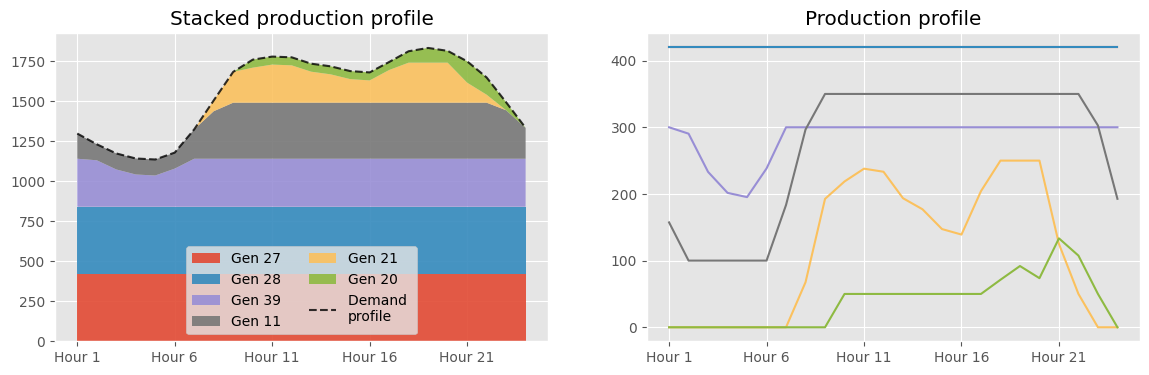

In [9]:
generators_turned_on = on_off.sum(axis=1) != 0

system.pmax['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmax = system.pmax.set_index('index')

system.pmin['index'] = [f'Gen {i}' for i in range(1, system.N_g+1)]
system.pmin = system.pmin.set_index('index')

# Check if power balance equation is satisfied 
power_balance = pd.DataFrame(
    [system.demand_profile.sum(axis=1).values, power.sum(axis=0).values, eps.flatten(), delta.flatten(), (eps + delta).flatten()], 
    index=['demand', 'power', 'eps', 'delta', 'slack_sum'
]).T
assert np.allclose(power_balance['demand'], power_balance[['power', 'eps', 'delta']].sum(axis=1)), 'Power balance equation not satisfied !'

power['total_production'] = power[generators_turned_on].cumsum(axis=1)['Hour 24']


fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=False, sharex=False)
axs[0].stackplot(
    np.arange(1, 25), 
    power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production'), 
    labels=power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').index,
    alpha=0.9,
)
axs[0].plot(np.arange(1,25), power_balance['demand'], color='k', ls='--', alpha=0.8, label='Demand \nprofile')
axs[0].set_title('Stacked production profile')
axs[0].set_xticks(np.arange(1, 25)[::5], [f'Hour {i+1}' for i in range(24)][::5])
axs[0].legend(loc='lower center', ncols=2)

power[generators_turned_on].sort_values(by='total_production', ascending=False).drop(columns='total_production').T.plot(title='Production profile', ax=axs[1], legend=False)

plt.show()

C:\Users\alber\AppData\Local\Temp\ipykernel_25760\3329453753.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors                  = ['green' if gen_ in generators_turned_on[active_].index else 'red' for gen_ in c_op_['Generator unit']]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\alber\AppData\Local\Temp\ipykernel_25760\3329453753.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].set_xticks(np.arange(len(c_op_)), c_op_['Generator unit'].apply(lambda x: x if x in generators_turned_

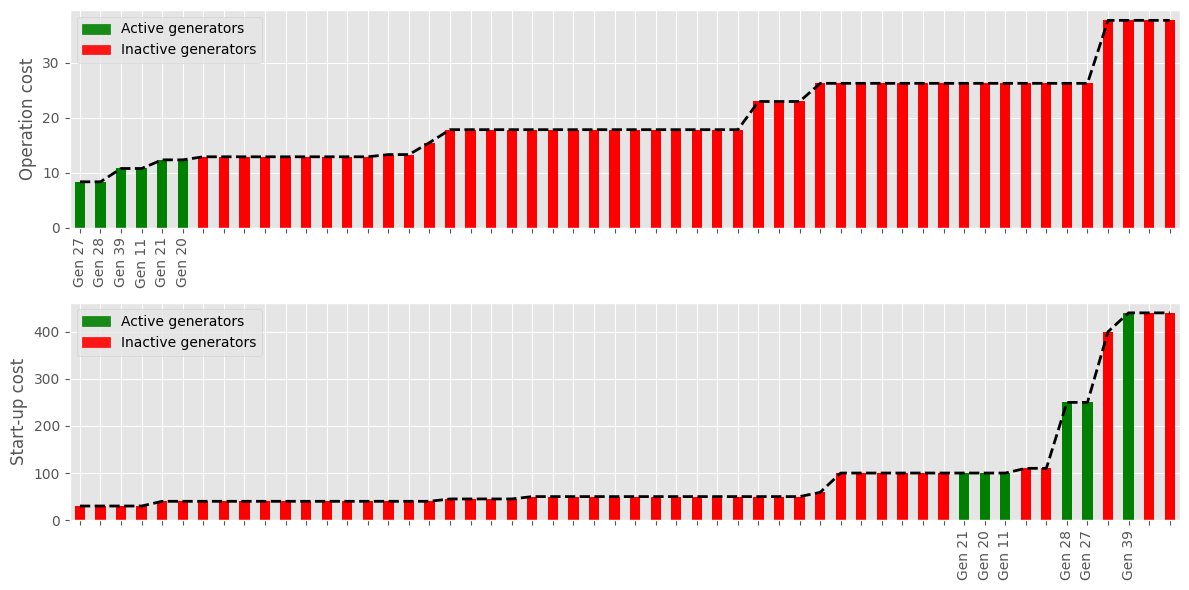

In [10]:
c_op_   = c_op.copy()
c_st_   = c_st.copy()

active_ = np.where(generators_turned_on == 1)[0]

handles = [plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.9),
           plt.Rectangle((0, 0), 1, 1, color='red', alpha=0.9)]

fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharey='row', sharex=False)
### PLOT OPERATION COST ###
c_op_['Generator unit'] = power.index
c_op_                   = c_op_.sort_values(by='cost_op', ascending=True)
colors                  = ['green' if gen_ in generators_turned_on[active_].index else 'red' for gen_ in c_op_['Generator unit']]

c_op_.plot(x='Generator unit', y='cost_op', kind='line', color='k', linewidth=2, ls='--', legend=False, ax=axs[0])
c_op_.plot(x='Generator unit', y='cost_op', kind='bar', color=colors, legend=False, ax=axs[0])
plt.legend(loc='upper right')
axs[0].set_xticks(np.arange(len(c_op_)), c_op_['Generator unit'].apply(lambda x: x if x in generators_turned_on[active_] else '').values)
axs[0].legend(handles, ['Active generators', 'Inactive generators'], loc='upper left')
axs[0].set_ylabel('Operation cost')
axs[0].set_xlabel('')

### PLOT START-UP COST ###
c_st_['Generator unit']  = power.index
c_st_                    = c_st_.sort_values(by='cost_st', ascending=True)
colors                  = ['green' if gen_ in generators_turned_on[active_].index else 'red' for gen_ in c_st_['Generator unit']]

c_st_.plot(x='Generator unit', y='cost_st', kind='line', color='k', linewidth=2, ls='--', legend=False, ax=axs[1])
c_st_.plot(x='Generator unit', y='cost_st', kind='bar', color=colors, legend=False, ax=axs[1])
axs[1].set_xticks(np.arange(len(c_st_)), c_st_['Generator unit'].apply(lambda x: x if x in generators_turned_on[active_] else '').values)
axs[1].legend(handles, ['Active generators', 'Inactive generators'], loc='upper left')
axs[1].set_ylabel('Start-up cost')
axs[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [11]:
temp_                   = pmin.iloc[active_].merge(pmax.iloc[active_], on='index').reset_index(drop=True)
temp_                   = pd.concat([temp_, UT.iloc[active_].reset_index(drop=True), DT.iloc[active_].reset_index(drop=True)], axis=1)
temp_                   = pd.concat([temp_, c_st.iloc[active_].reset_index(drop=True), c_op.iloc[active_].reset_index(drop=True)], axis=1)
temp_                   = temp_.set_index('index')
temp_

,pmin,pmax,lu,ld,cost_st,cost_op
index,,,,,,
Gen 11,100,350,8,8,100,10.7600
Gen 20,50,250,8,8,100,12.3299
Gen 21,50,250,8,8,100,12.3299
Gen 27,100,420,10,10,250,8.3391
Gen 28,100,420,10,10,250,8.3391
Gen 39,100,300,8,8,440,10.7600


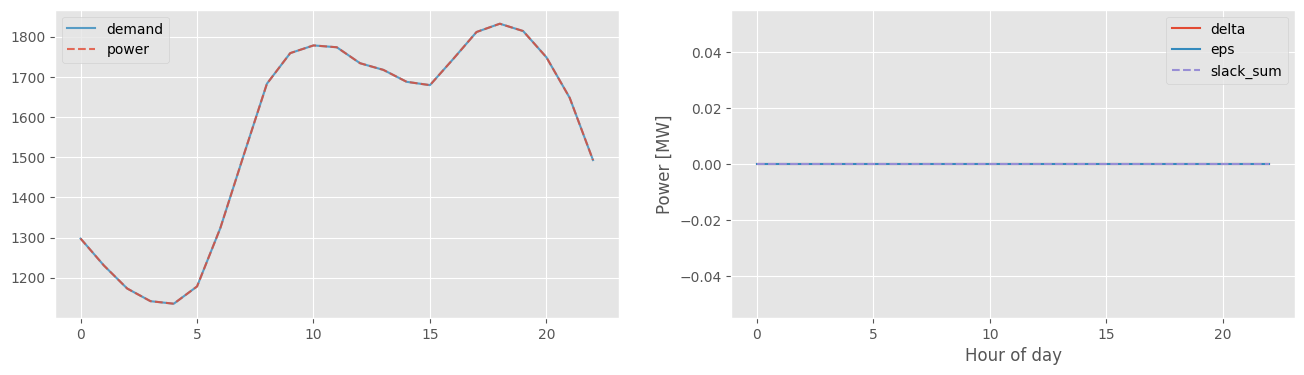

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4)) 
power_balance[:-1].plot(y=['demand'], color='C1', ls='-', alpha=0.8, ax=axs[0])
power_balance[:-1].plot(y=['power'], color='C0', ls='--', alpha=0.8, ax=axs[0])
power_balance[:-1].plot(y=['delta', 'eps'],      ax=axs[1])
power_balance[:-1].plot(y='slack_sum', ls='--',  ax=axs[1])
plt.xlabel('Hour of day')
plt.ylabel('Power [MW]')
plt.show()

Total cost of the system:  345277.8616414702


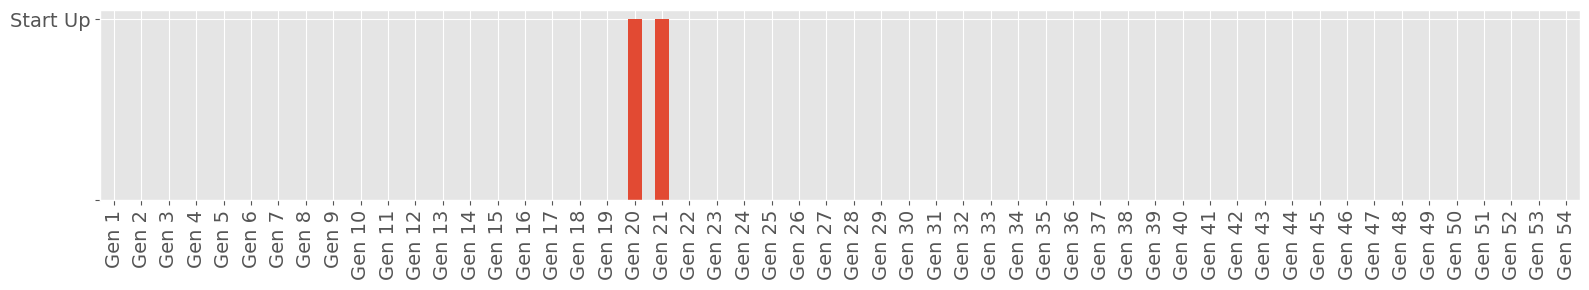

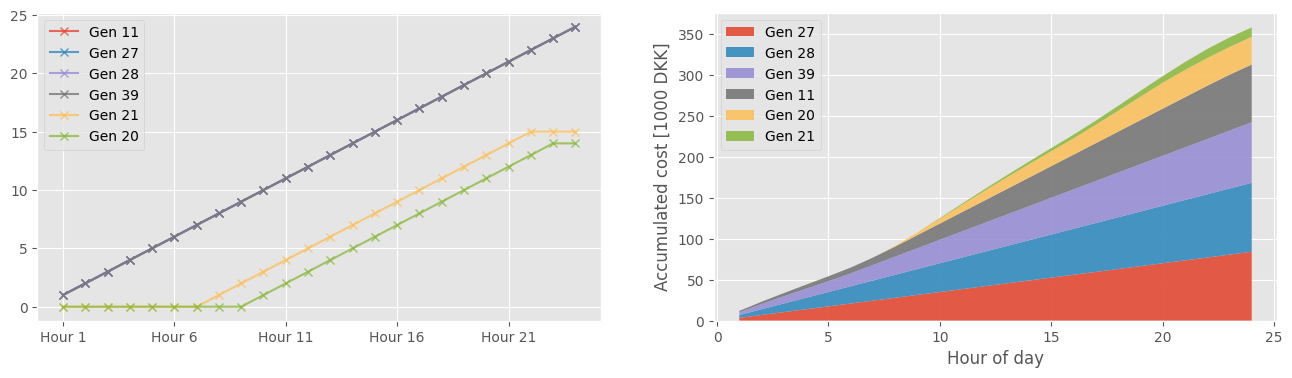

,Hour 6,Hour 7,Hour 8,Hour 9,Hour 10,Hour 11,Hour 12,Hour 13,Hour 14,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
Gen 20,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gen 21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print("Total cost of the system: ", sum(cost.iloc[:, :-1].values.flatten()))

# Shwo start up status
start_up.sum(axis=1).plot(kind='bar', figsize=(16, 3))
plt.yticks([0, 1], ['', 'Start Up'], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

### Create production cost curves
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
generators_turned_on = on_off.sum(axis=1) != 0

# Visalize when the generators are turned on
on_off[generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False).T.plot(ax=axs[0], ls='-', marker='x', alpha=0.8)

# Visualize the cost of the system for each turned on generator
axs[1].stackplot(
    np.arange(1, 25), 
    cost.iloc[:, :][generators_turned_on].cumsum(axis=1).sort_values(by='Hour 24', ascending=False) / 1000, 
    labels=cost.iloc[:, :][generators_turned_on].sort_values(by='Hour 24', ascending=False).index,
    alpha=0.9,
)
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Hour of day')
axs[1].set_ylabel('Accumulated cost [1000 DKK]')
plt.show()

start_up[start_up.sum(axis=1) != 0].iloc[:, 5:]

### Finding active constraints

In [14]:
constraints = pd.DataFrame([{
    'constr_type': c.ConstrName.split('[')[0] if '[' in c.ConstrName else c.ConstrName, 
    'constr_level': '[' + c.ConstrName.split('[')[1] if '[' in c.ConstrName else '-', 
    'constraint_slack': c.Slack, 
    'rhs': c.getAttr('rhs')
} for c in system.model.getConstrs()])

grouped_constraints = {}
for name in tqdm(constraints['constr_type'].unique()):
    grouped_constraints[name] = constraints.query('constr_type == @name').reset_index(drop=True)

100%|██████████| 57/57 [00:00<00:00, 630.01it/s]


In [15]:
pos_line_flow_limits            = grouped_constraints['pos_line_flow_limit']
pos_line_flow_limits['l']       = pos_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
pos_line_flow_limits['t']       = pos_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))
pos_line_flow_limits['active']  = (abs(pos_line_flow_limits['constraint_slack']) < 1e-3).astype(int)

# Extract as dataframe
pos_active_lines                = pd.pivot_table(pos_line_flow_limits, index='t', columns='l', values='active', aggfunc='sum')
pos_active_lines.columns        = [f'Line {i+1}' for i in range(system.N_lines)]
pos_active_lines.index          = [f'Hour {i+1}' for i in range(system.N_t)]

print((abs(pos_line_flow_limits.constraint_slack) < 1e-3).sum())
pos_line_flow_limits.head()

100%|██████████| 4464/4464 [00:00<00:00, 558090.35it/s]

0


,constr_type,constr_level,constraint_slack,rhs,l,t,active
0,pos_line_flow_limit,"[0,0]",181.809822,182.074869,0,0,0
1,pos_line_flow_limit,"[1,0]",187.422726,187.157679,1,0,0
2,pos_line_flow_limit,"[2,0]",520.040732,518.744275,2,0,0
3,pos_line_flow_limit,"[3,0]",193.907642,193.304826,3,0,0
4,pos_line_flow_limit,"[4,0]",154.555887,155.650972,4,0,0


In [16]:
neg_line_flow_limits            = grouped_constraints['neg_line_flow_limit']
neg_line_flow_limits['l']       = neg_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[0]))
neg_line_flow_limits['t']       = neg_line_flow_limits['constr_level'].progress_apply(lambda x: int(x.strip('[').strip(']').split(',')[1]))
neg_line_flow_limits['active']  = (abs(neg_line_flow_limits['constraint_slack']) < 1e-3).astype(int)

# Extract as dataframe
neg_active_lines = pd.pivot_table(neg_line_flow_limits, index='t', columns='l', values='active', aggfunc='sum')
neg_active_lines.columns = [f'Line {i+1}' for i in range(system.N_lines)]
neg_active_lines.index = [f'Hour {i+1}' for i in range(system.N_t)]

print((abs(neg_line_flow_limits.constraint_slack) < 1e-3).sum())
neg_line_flow_limits.head()

100%|██████████| 4464/4464 [00:00<00:00, 557840.93it/s]


0


,constr_type,constr_level,constraint_slack,rhs,l,t,active
0,neg_line_flow_limit,"[0,0]",-168.190178,-167.925131,0,0,0
1,neg_line_flow_limit,"[1,0]",-162.577274,-162.842321,1,0,0
2,neg_line_flow_limit,"[2,0]",-479.959268,-481.255725,2,0,0
3,neg_line_flow_limit,"[3,0]",-156.092358,-156.695174,3,0,0
4,neg_line_flow_limit,"[4,0]",-195.444113,-194.349028,4,0,0


In [17]:
slack_line_vals_neg = neg_line_flow_limits['constraint_slack'] - neg_line_flow_limits['rhs']
slack_line_vals_pos = pos_line_flow_limits['constraint_slack'] - pos_line_flow_limits['rhs']

np.allclose(abs(slack_line_vals_pos), abs(slack_line_vals_neg))

True

<a class="anchor" id="machine-learning"></a>
## 4. Can we solve the problem using machine learning?

In the script ```src/assignment3/run_optimization.py``` the optimization model was run for a large variety of demand load profiles. In order to create a data set for the machine learning problem, the binary variables and line flow constraints were saved.

In [18]:
import glob
from pathlib import Path

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

### Load data files

In [19]:
file_idx                        = 0

pos_active_lines_files          = sorted(glob.glob((PROCESSED_DIR / 'active_pos*.csv').as_posix()), key=lambda x: len(x))
neg_active_lines_files          = sorted(glob.glob((PROCESSED_DIR / 'active_neg*.csv').as_posix()), key=lambda x: len(x))
on_off_files                    = sorted(glob.glob((PROCESSED_DIR / 'on_off_*.csv').as_posix()), key=lambda x: len(x))
start_up_files                  = sorted(glob.glob((PROCESSED_DIR / 'start_up_*.csv').as_posix()), key=lambda x: len(x))

for i in range(len(pos_active_lines_files)):

    active_pos_lines_           = pd.read_csv(pos_active_lines_files[file_idx], index_col=None, header=None)
    active_pos_lines_.index     = [f'Hour {i % 24 + 1}' for i in range(active_pos_lines_.shape[0])]
    active_pos_lines_.columns   = [f'Line {i+1}' for i in range(active_pos_lines_.shape[1])]

    active_neg_lines_           = pd.read_csv(neg_active_lines_files[file_idx], index_col=None, header=None)
    active_neg_lines_.index     = [f'Hour {i % 24 + 1}' for i in range(active_neg_lines_.shape[0])]
    active_neg_lines_.columns   = [f'Line {i+1}' for i in range(active_neg_lines_.shape[1])]

    on_off_                     = pd.read_csv(on_off_files[file_idx], index_col=None, header=None)
    on_off_.index               = [f'Gen {i % 54 +1}' for i in range(on_off_.shape[0])]
    on_off_.columns             = [f'Hour {i+1}' for i in range(on_off_.shape[1])]

    start_up_                   = pd.read_csv(start_up_files[file_idx], index_col=None, header=None)
    start_up_.index             = [f'Gen {i % 54 +1}' for i in range(start_up_.shape[0])]
    start_up_.columns           = [f'Hour {i+1}' for i in range(start_up_.shape[1])]

    if i == 0:
        on_off                  = on_off_
        start_up                = start_up_
        active_pos_lines = active_pos_lines_
        active_neg_lines = active_neg_lines_
    else:
        on_off                  = pd.concat([on_off, on_off_], axis=0)
        start_up                = pd.concat([start_up, start_up_], axis=0)
        active_pos_lines        = pd.concat([active_pos_lines, active_pos_lines_], axis=0)
        active_neg_lines        = pd.concat([active_neg_lines, active_neg_lines_], axis=0)

print(on_off.shape[0] // 54)

1386


Below, we visualize the data set of binary variables - it is rather sparse, as can be seen.

Total number of active lines (positive flow): 84
Total number of active lines (negative flow): 4


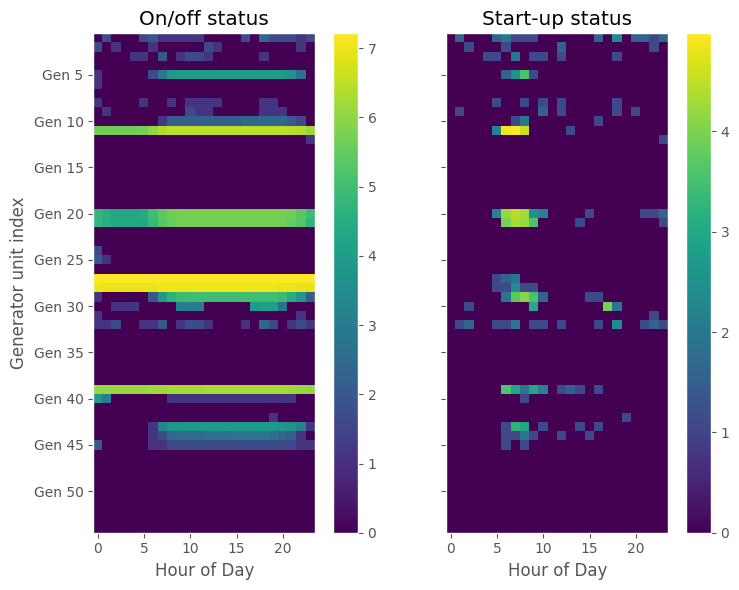

In [20]:
print(f"Total number of active lines (positive flow): {active_pos_lines.sum().sum()}")
print(f"Total number of active lines (negative flow): {active_neg_lines.sum().sum()}")

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
for i, df_ in enumerate([on_off.copy(), start_up.copy()]):
    gen_idx = df_.reset_index()['index'].apply(lambda x: int(x.split(" ")[1]))
    df_ = df_.reset_index(drop=True)
    df_['gen_idx'] = gen_idx

    im = axs[i].imshow(np.log(df_.groupby('gen_idx').sum() + 1))    
    axs[i].grid(None)
    plt.colorbar(im)
    
    axs[i].set_xlabel('Hour of Day')
    axs[i].set_title('On/off status' if i==0 else 'Start-up status')
axs[0].set_ylabel('Generator unit index')
axs[0].set_yticks(np.arange(4, 54, 5), [f'Gen {i+1}' for i in range(4, 54, 5)])

plt.tight_layout()
plt.show()

As is seen on the Figure, many of the power generating units were not turned on at all when exploiting the provided samples of load. Thus, if we wish to create a binary machine learning model that can predict across all hours of a day (i.e. 24 hours), we need to consider this fact as it restricts the modeling task. In general, we regard the task as being that of predicting a sequence of 24 binary variables (e.g. whether the generator unit is turned on or off) given a sequence of 24 load values (and other data soures). If a generator unit is never turned on for some hours, the binary machine learning model will not be able to learn anything about this hour, thus resulting in selecting to remove these generation units. Additionally, this means that we will not really be able of modeling the start-up status of the generator units, as the start-up pattern obtained from historical data is very sparse.

### Creating the data set

First, we start by defining the targets for the on-off generation task. We solve the task in a supervised manner and restrict 

In [21]:
targets                 = on_off.copy()
targets['SampleIndex']  = np.arange(targets.shape[0]) // 54 

unique_generators       = targets.drop('SampleIndex', axis=1).reset_index().groupby(['index']).sum().sum(axis=1) != 0
unique_generators       = targets.loc[unique_generators].index.unique()

targets                 = targets.reset_index().rename(columns={'index': 'Generator'}).melt(id_vars=['SampleIndex', 'Generator'])
targets['Hour']         = targets['SampleIndex'] * 24 + targets['variable'].apply(lambda x: int(x.split(' ')[1]))
targets                 = pd.pivot_table(targets, index='SampleIndex', columns=['Generator', 'variable'], values='value')

col_order   = sorted(sorted(list(zip(targets.columns.get_level_values(0), targets.columns.get_level_values(1))), key=lambda x: int(x[1].split(' ')[1])), key=lambda x: int(x[0].split(' ')[1]))
targets     = targets[col_order].astype(int)
print(targets.shape)

valid_gens = []
for gen_ in tqdm([f'Gen {i+1}' for i in range(54)], desc='Retrieving valid generators...'):
    if targets[gen_].sum(axis=0).all():
        valid_gens += [gen_]

print(f"\nMulti-class targets")
multiclass_targets = targets[unique_generators]
print(unique_generators)
print(multiclass_targets.shape)

print(f"\nMulti-label targets")
multilabel_targets = targets[valid_gens]
print(valid_gens)
print(multilabel_targets.shape)

(1386, 1296)


Retrieving valid generators...: 100%|██████████| 54/54 [00:00<00:00, 997.61it/s]


Multi-class targets
Index(['Gen 1', 'Gen 2', 'Gen 3', 'Gen 5', 'Gen 6', 'Gen 8', 'Gen 9', 'Gen 10',
       'Gen 11', 'Gen 12', 'Gen 20', 'Gen 21', 'Gen 24', 'Gen 25', 'Gen 27',
       'Gen 28', 'Gen 29', 'Gen 30', 'Gen 31', 'Gen 32', 'Gen 39', 'Gen 40',
       'Gen 42', 'Gen 43', 'Gen 44', 'Gen 45'],
      dtype='object')
(1386, 624)

Multi-label targets
['Gen 11', 'Gen 20', 'Gen 21', 'Gen 27', 'Gen 28', 'Gen 39']
(1386, 144)


Next, we define the features of the dataset. These are considered to be:
1) The demand profiles per day
2) ...

In [22]:
demand  = pd.read_csv(DATA_DIR / 'demand.csv', sep=';')
samples = pd.read_csv(DATA_DIR / 'samples.csv', header=None)
# FIX ISSUE THAT ALBERT DID WHILE CREATING THE DATA - SKIPPED ONE SAMPLE
samples = samples.drop(693).reset_index(drop=True)

load_profiles = np.array([demand * samples.iloc[i, :].values[np.newaxis, :] for i in range(len(on_off) // 54)])
print(load_profiles.shape)

columns_ = [f'Load {i+1} - Hour {j+1}' for j in range(load_profiles.shape[2]) for i in range(load_profiles.shape[1])]
load_profiles = np.vstack([load_profiles[i, :, :].flatten() for i in range(load_profiles.shape[0])])
load_profiles = pd.DataFrame(load_profiles, columns=columns_)
print(load_profiles.shape)

load_profiles.head()

(1386, 24, 91)
(1386, 2184)


,Load 1 - Hour 1,Load 2 - Hour 1,Load 3 - Hour 1,Load 4 - Hour 1,Load 5 - Hour 1,Load 6 - Hour 1,Load 7 - Hour 1,Load 8 - Hour 1,Load 9 - Hour 1,Load 10 - Hour 1,...,Load 15 - Hour 91,Load 16 - Hour 91,Load 17 - Hour 91,Load 18 - Hour 91,Load 19 - Hour 91,Load 20 - Hour 91,Load 21 - Hour 91,Load 22 - Hour 91,Load 23 - Hour 91,Load 24 - Hour 91
0,19.232548,6.926455,12.733231,9.479191,17.288109,6.901182,22.343626,10.335770,5.835385,1.767882,...,3.9130,3.0940,0.2414,0.9072,4.3407,2.7300,0.891450,2.402715,2.706825,4.48800
1,5.891752,1.885185,3.105719,2.062746,4.069920,1.638694,5.603810,2.964141,1.969397,0.746587,...,7.7959,5.6168,0.4199,1.4784,8.2446,5.8275,2.097879,6.047650,6.424198,10.29435
2,6.226399,2.630011,5.486777,4.274608,7.674662,2.844579,8.160354,3.662895,2.282587,0.863776,...,13.9664,12.1618,0.8483,2.7048,13.5681,8.9950,3.155733,8.058085,8.878386,13.60425
3,3.158315,1.374068,2.834605,2.115867,3.096773,1.509656,5.742245,2.858099,1.807403,0.641646,...,17.6085,14.2800,1.0081,3.2480,15.3426,9.5200,3.173562,8.221535,9.870889,15.76410
4,1.651378,0.484954,0.728867,0.434149,1.114263,0.450052,1.462646,0.813238,0.656339,0.336940,...,12.2507,8.2348,0.5338,1.6464,7.3983,4.1650,1.200486,1.830640,1.912823,2.97330


In [23]:
# OUTPUT: binary generator on/off status
# OUTPUT: active constraints (on transmission lines)

# DONE # INPUT: load profile
# DONE # INPUT: demand
# INPUT: time (hours)               --> np.vstack([np.cos(np.arange(24)*2*np.pi/24), np.cos(np.arange(24)*2*np.pi/24)]).shape
# INPUT: ramping up/down            --> ...
# INPUT: minimum on/off time        --> ...
# INPUT: cost of operation          --> ...
# INPUT: cost of start-up           --> ...

### Multi-label approach - training and evaluating the model

In [24]:
from pprint import pprint
from collections import defaultdict

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, roc_curve

In [25]:
def compute_auc_plot_roc(ytest_gen, yhat_probs, gen_, axs, task: str = 'multilabel'):
    auc_score = {}

    if task == 'multilabel':
        for label_idx in range(24):
            auc_score[f'Hour {label_idx+1}']    = roc_auc_score(ytest_gen.iloc[:, label_idx], yhat_probs[label_idx][:, 1])
            roc                                 = roc_curve(ytest_gen.iloc[:, label_idx], yhat_probs[label_idx][:, 1], )
            
            axs[gen_idx].plot(roc[0], roc[1], label='Hour {}'.format(label_idx+1))
            
        axs[gen_idx].set_title(gen_)
        axs[gen_idx].set_xlabel('False positive rate')
        axs[gen_idx].set_ylabel('True positive rate')

        return np.mean(list(auc_score.values()))
    
    else:
        raise NotImplementedError("Multi-target not implemented yet!")

In [26]:
X = load_profiles[:600]
y = multilabel_targets[:600]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

preds   = {}
scores  = defaultdict(dict)

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(26, 4))
for gen_idx, gen_ in enumerate(tqdm(valid_gens, desc='Training models for each generator...')):
    ytrain_gen      = ytrain[gen_]
    ytest_gen       = ytest[gen_]

    svc             = SVC(probability=True, random_state=42)
    model           = MultiOutputClassifier(svc)
    model.fit(Xtrain, ytrain_gen)

    yhat_probs      = model.predict_proba(Xtest)
    yhat_gen        = model.predict(Xtest)
    preds[gen_]     = yhat_gen
    
    scores[gen_]['accuracy']            = accuracy_score(ytest_gen, yhat_gen)
    scores[gen_]['average_auc']         = compute_auc_plot_roc(ytest_gen, yhat_probs, gen_, axs)
    scores[gen_]['f1_score']            = f1_score(ytest_gen, yhat_gen, average='weighted')
    scores[gen_]['recall_score']        = recall_score(ytest_gen, yhat_gen, average='weighted')
    scores[gen_]['precision_score']     = precision_score(ytest_gen, yhat_gen, average='weighted')

plt.show()

scores = pd.DataFrame.from_dict(dict(scores)).T
scores

Training models for each generator...:  50%|█████     | 3/6 [00:18<00:18,  6.04s/it]

In [ ]:
fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(10, 6))
for gen_idx, gen_ in enumerate(valid_gens):
    im = axs[gen_idx].imshow((preds[gen_] - ytest[gen_]))
    axs[gen_idx].grid(None)
    axs[gen_idx].set_title(gen_)
    axs[gen_idx].set_xlabel('Hour of day')

axs[0].set_ylabel('Test set index')
plt.colorbar(im)
fig.suptitle('Prediction error, i.e. $\hat{y} - y$', fontsize=16)
plt.tight_layout()
plt.show()

### Multi-target approach??? CURRENTLY BROKEN

In [ ]:
# plt.figure( figsize=(10, 3))
# plt.imshow(multilabel_targets.T)
# plt.colorbar()
# plt.grid(None)
# plt.tight_layout()
# plt.show()

In [ ]:
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import LinearSVC


# X = load_profiles[:600]
# y_ = multiclass_targets[:600]

# preds   = {}
# scores  = defaultdict(dict)

# fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(26, 4))
# for gen_idx, gen_ in tqdm(enumerate(valid_gens), desc='Training models for each generator...'):
#     y = LabelBinarizer().fit_transform(y_[gen_])

#     Xtrain, Xtest, ytrain_gen, ytest_gen = train_test_split(X, y, test_size=0.2, random_state=42)

#     # svc     = LinearSVC(dual="auto", random_state=0)
#     svc             = SVC(probability=True, random_state=42)
#     model           = OneVsRestClassifier(svc)
#     model.fit(Xtrain, ytrain_gen)

#     # yhat_gen        = model.predict(Xtest)
#     # scores[gen_]    = accuracy_score(ytest[gen_], yhat_gen)
#     # preds[gen_]     = yhat_gen

    
#     yhat_probs      = model.predict_proba(Xtest)
#     yhat_gen        = model.predict(Xtest)
#     preds[gen_]     = yhat_gen
    
#     scores[gen_]['balanced_accuracy']   = accuracy_score(ytest_gen, yhat_gen)
#     scores[gen_]['average_auc']         = compute_auc_plot_roc(pd.DataFrame(ytest_gen, columns=[f'Hour {i+1}' for i in range(24)]), pd.DataFrame(yhat_probs, columns=[f'Hour {i+1}' for i in range(24)]), gen_, axs)
#     scores[gen_]['f1_score']            = f1_score(ytest_gen, yhat_gen, average='weighted')
#     scores[gen_]['recall_score']        = recall_score(ytest_gen, yhat_gen, average='weighted')
#     scores[gen_]['precision_score']     = precision_score(ytest_gen, yhat_gen, average='weighted')

# plt.show()

# scores = pd.DataFrame.from_dict(dict(scores)).T
# scores

<a class="anchor" id="extra"></a>
## 5. Extra